In [83]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StringType, BooleanType, IntegerType, DoubleType, NumericType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.functions import vector_to_array
import pyspark

In [161]:
spark = SparkSession.builder.appName("myapp").master('local[*]').getOrCreate()

In [162]:
df = spark.read.csv('dataset/Base.csv', header=True, inferSchema=True)

In [163]:
# Add _encoded to month column
df = df.withColumnRenamed('month', 'month_encoded')

In [164]:
# Creating a list of the categorical features in the dataset
categorical_variables = [col for col in df.columns
                         if isinstance(df.schema[col].dataType, StringType)]

print(categorical_variables)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [165]:
# Step 1: Create StringIndexers for each column
indexers = [StringIndexer(inputCol=col, outputCol=col + "_encoded") for col in categorical_variables]

# Step 2: Create a pipeline with only the indexers
pipeline = Pipeline(stages=indexers)

# Step 3: Fit the pipeline and transform the DataFrame
df_encoded = pipeline.fit(df).transform(df)

# Step 4: Select the new index columns, along with other columns if needed
indexed_column_names = [col + "_encoded" for col in categorical_variables]
other_columns = [col for col in df.columns if col not in categorical_variables]  # Get other original columns

df_final = df_encoded.select(*other_columns, *indexed_column_names)

# Show the transformed DataFrame
df_final.show()

+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-------------+----------------+------------------+-----------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|bank_month

In [166]:
#Explicitly filter columns that are IntegerType or DoubleType
numerical_features = [
    col for col in df_final.columns
    if isinstance(df_final.schema[col].dataType, (IntegerType, DoubleType))
]

print("Numerical Features:")
print(numerical_features)

Numerical Features:
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month_encoded', 'payment_type_encoded', 'employment_status_encoded', 'housing_status_encoded', 'source_encoded', 'device_os_encoded']


In [167]:
# Remove from the list all the columns ending with _encoded as they are categorical
numerical_features = [col for col in numerical_features if not col.endswith("_encoded")]

print("Numerical Features (excluding encoded columns):")
print(numerical_features)

Numerical Features (excluding encoded columns):
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count']


In [168]:
#Apply MinMax norm
# Step 2: Assemble these numeric features into a single vector column
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features_vector")

# Step 3: Apply MinMaxScaler to scale the vector to [0, 1] range
scaler = MinMaxScaler(inputCol="features_vector", outputCol="scaled_features_vector")

# Step 4: Apply the assembler and scaler in sequence
df_transformed = assembler.transform(df_final)
df_transformed = scaler.fit(df_transformed).transform(df_transformed)

# Step 5: Convert the scaled vector back into individual columns and overwrite the original columns
df_transformed = df_transformed.withColumn("scaled_features_array", vector_to_array(col("scaled_features_vector")))

# Step 6: Overwrite each original column with its scaled value
for i, feature_name in enumerate(numerical_features):
    df_transformed = df_transformed.withColumn(feature_name, col("scaled_features_array")[i])

# Step 7: Drop intermediate columns to retain only the original set of columns with normalized values
df_transformed = df_transformed.drop("features_vector", "scaled_features_vector", "scaled_features_array")

In [169]:
from pyspark.sql.functions import countDistinct

zero_variance_cols = [
    col_name for col_name in numerical_features
    if df_transformed.select(countDistinct(col_name)).collect()[0][0] <= 1
]

df_transformed = df_transformed.drop(*zero_variance_cols)

In [136]:
df_transformed.show()

+-----+-------------------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+-------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|label|             income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|        velocity_6h|       velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|  bank_mo

# Classification with GBTClassifier and base dataset

In [198]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [181]:
# Rename target_bool column to label
df_transformed = df_transformed.withColumnRenamed("target_bool", "label")

In [187]:
# Get a list of the columns in the dataset
columns = df_transformed.columns

# Remove the target column from the list
columns.remove("label")

In [188]:
assembler = VectorAssembler(inputCols=columns, outputCol='features')
data_transformed = assembler.transform(df_transformed)

In [189]:
# Prepare the final dataset
dataset = data_transformed.select('features', 'label')  # Ensure you have 'features' and 'label' columns

In [190]:
train_data, test_data = dataset.randomSplit([0.8, 0.2], seed=42)

In [191]:
gbt = GBTClassifier(maxIter=10, maxDepth=5, labelCol="label", seed=42,
                    leafCol="LeafId", featuresCol="features")

In [192]:
model = gbt.fit(train_data)

24/11/30 19:26:44 WARN MemoryStore: Not enough space to cache rdd_338_7 in memory! (computed 7.9 MiB so far)
24/11/30 19:26:44 WARN MemoryStore: Not enough space to cache rdd_338_8 in memory! (computed 5.2 MiB so far)
24/11/30 19:26:44 WARN MemoryStore: Not enough space to cache rdd_338_10 in memory! (computed 3.5 MiB so far)
24/11/30 19:26:44 WARN MemoryStore: Not enough space to cache rdd_338_5 in memory! (computed 5.2 MiB so far)
24/11/30 19:26:44 WARN MemoryStore: Not enough space to cache rdd_338_1 in memory! (computed 7.9 MiB so far)
24/11/30 19:26:44 WARN MemoryStore: Not enough space to cache rdd_338_11 in memory! (computed 7.9 MiB so far)
24/11/30 19:26:44 WARN MemoryStore: Not enough space to cache rdd_338_9 in memory! (computed 7.9 MiB so far)
24/11/30 19:26:44 WARN MemoryStore: Not enough space to cache rdd_338_3 in memory! (computed 7.9 MiB so far)
24/11/30 19:26:44 WARN MemoryStore: Not enough space to cache rdd_338_2 in memory! (computed 7.9 MiB so far)
24/11/30 19:26:44

In [194]:
predictions = model.transform(test_data)

# Show the predictions
predictions.select('features', 'label', 'prediction', 'probability').show()

24/11/30 19:30:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/30 19:30:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93264397867674...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93294727107968...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93345378823264...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93264397867674...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93310310747216...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93281631827932...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93014696265689...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93247766908780...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93310310747216...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.91423609471675...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.92894477911713...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.92894477911713...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93261877446046...|
|(30,[0,1,2,3,4,5,...|  

In [199]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calculate accuracy
auc = evaluator.evaluate(predictions)
print(f"AUC = {auc:.2f}")

AUC = 0.85


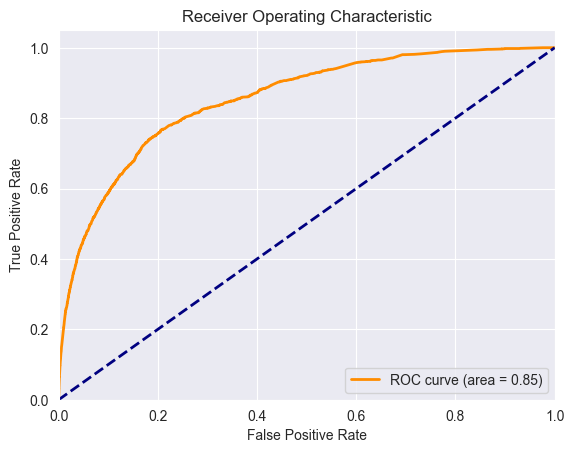

In [200]:
#Plot the ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convert the DataFrame to a Pandas DataFrame
predictions_pd = predictions.select('label', 'probability').toPandas()

# Get the actual values and the predicted probabilities
y_true = predictions_pd['label']
y_prob = predictions_pd['probability'].apply(lambda x: x[1])

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()